In [9]:
import pandas as pd
from pyspark.sql import (
    functions as f,
    SparkSession,
    types as t
)
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import (
    ParamGridBuilder,
    CrossValidator
)

# https://grouplens.org/datasets/movielens/100k/
# https://spark.apache.org/docs/latest/ml-collaborative-filtering.html
spark = SparkSession.builder.appName("ml_als").getOrCreate()

# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.recommendation.ALS.html
# Alternating Least Squares (ALS) matrix factorization.
# Collaborative Filtering approach

schema = t.StructType([
     t.StructField("user_id", t.IntegerType(), True),
     t.StructField("movie_id", t.IntegerType(), True),
     t.StructField("rating", t.IntegerType(), True),
     t.StructField("timestamp", t.LongType(), True)])

df = spark.read.option("sep", "\t").schema(schema).csv(
    "file:///home/jovyan/work/sample/u.data", header=False, inferSchema=True)
df.show()
(training, test) = df.randomSplit([0.8, 0.2])

training.describe().show()
test.describe().show()

training.cache()
test.cache()

+-------+--------+------+---------+
|user_id|movie_id|rating|timestamp|
+-------+--------+------+---------+
|    196|     242|     3|881250949|
|    186|     302|     3|891717742|
|     22|     377|     1|878887116|
|    244|      51|     2|880606923|
|    166|     346|     1|886397596|
|    298|     474|     4|884182806|
|    115|     265|     2|881171488|
|    253|     465|     5|891628467|
|    305|     451|     3|886324817|
|      6|      86|     3|883603013|
|     62|     257|     2|879372434|
|    286|    1014|     5|879781125|
|    200|     222|     5|876042340|
|    210|      40|     3|891035994|
|    224|      29|     3|888104457|
|    303|     785|     3|879485318|
|    122|     387|     5|879270459|
|    194|     274|     2|879539794|
|    291|    1042|     4|874834944|
|    234|    1184|     2|892079237|
+-------+--------+------+---------+
only showing top 20 rows

+-------+-----------------+------------------+------------------+-------------------+
|summary|          user_

DataFrame[user_id: int, movie_id: int, rating: int, timestamp: bigint]

In [10]:
# coldStartStrategy: drop if the prediction is NaN
als = ALS(
        userCol="user_id",
        itemCol="movie_id",
        ratingCol="rating",
        coldStartStrategy="drop",
        nonnegative=True)

# Evaluate the model by computing the RMSE on the test data
# the absolute fit of the model to the data–how close the observed data points are to the model's predicted values.
# RMSE values between 0.2 and 0.5 shows that the model can relatively predict the data accurately
# The lower the RMSE, the better a given model is able to “fit” a dataset.
evaluator = RegressionEvaluator(
                metricName="rmse",
                labelCol="rating",
                predictionCol="prediction")

In [11]:
# Builder for a param grid used in grid search-based model selection.
# regParam: control on your fitting parameters. As the magnitues of the fitting parameters increase, there will be an increasing penalty on the cost function
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [10, 100]) \
            .addGrid(als.regParam, [.1]) \
            .addGrid(als.maxIter, [10]) \
            .build()

# Cross Validation begins by splitting the dataset into a set of folds which are used as separate training and test datasets.
# get the best hyper parameter => re-fits the estimator using the best hyper parameter and the entire dataset
# estimator: algorithm or Pipeline to tune
# estimatorParamMaps: parameters to choose from
# evaluator: metric to measure how well a fitted Model does on held-out test data
cv = CrossValidator(
        estimator=als,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        numFolds=3,
        parallelism=6)

# 1. They split the input data into separate training and test datasets.
# 2. For each (training, test) pair, they iterate through the set of ParamMap
# 3. For each ParamMap, they fit the Estimator using those parameters, get the fitted Model, and evaluate the Model’s performance using the Evaluator.
# 4. They select the Model produced by the best-performing set of parameters.
# And magic happens here :D
# there is `TrainValidationSplit` that Spark offers but only evaluates each combination of parameters once, as opposed to k times in the case of CrossValidator
# It is therefore less expensive, but will not produce as reliable results when the training dataset is not sufficiently large


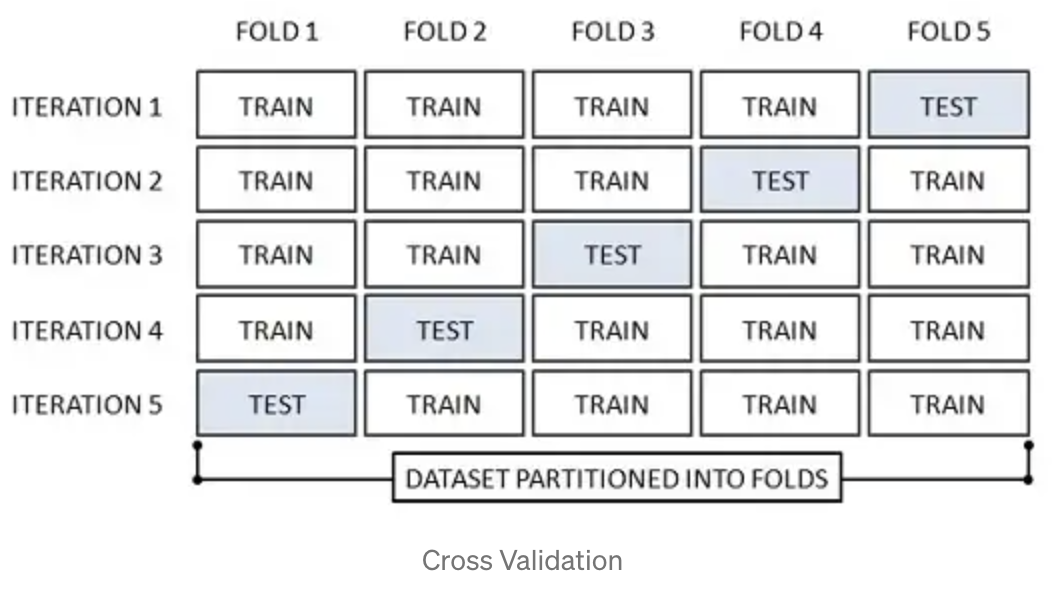

In [12]:
# build models
model = cv.fit(training)

# best model
best_model = model.bestModel

predictions = best_model.transform(test)

# check how close the prediction
predictions.sort("user_id", "rating").show()

+-------+--------+------+---------+----------+
|user_id|movie_id|rating|timestamp|prediction|
+-------+--------+------+---------+----------+
|      1|     254|     1|878541392| 1.9620037|
|      1|     261|     1|875692992| 2.1695025|
|      1|      29|     1|878542869| 2.3385112|
|      1|     231|     1|876893031|  2.542621|
|      1|     101|     2|878542845| 3.1223931|
|      1|     255|     2|885345822|  3.052937|
|      1|      11|     2|875072262| 3.9374752|
|      1|      94|     2|875072956| 2.7686672|
|      1|     252|     2|875240677| 2.3653934|
|      1|     245|     2|875071713| 2.7050736|
|      1|      99|     3|875072547| 3.7860358|
|      1|      83|     3|875072370| 3.8300178|
|      1|     125|     3|878542960| 3.3314655|
|      1|     139|     3|878543216| 2.5035188|
|      1|     188|     3|875073128| 3.8691542|
|      1|     153|     3|876893230| 3.8958397|
|      1|     217|     3|876892676| 3.3920357|
|      1|      25|     4|875071805| 3.2560954|
|      1|    

In [13]:
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {str(rmse)}")

# rank refers the presumed latent or hidden factors. how many factors were used to be best
print(f"Rank = {best_model._java_obj.parent().getRank()}")

# Print "MaxIter"
print(f"MaxIter = {best_model._java_obj.parent().getMaxIter()}")

# Print "RegParam"
print(f"RegParam = {best_model._java_obj.parent().getRegParam()}")

Root-mean-square error = 0.9164445185444907
Rank = 100
MaxIter = 10
RegParam = 0.1


In [14]:
# user specific
user_id = 200
user_schema = t.StructType([t.StructField("user_id", t.IntegerType(), True)])
users = spark.createDataFrame([[user_id,]], user_schema)

user_recs = best_model.recommendForUserSubset(users, 5).collect()

def get_movie_dict():
    # f = open("sample/u.item", "r")
    data = pd.read_csv('sample/u.item', sep='|', encoding='latin-1')
    return data.iloc[:, 1].to_dict()

# movie meta data
movie_name_dict = get_movie_dict()

# top 5
print("== recommendation ==")
for user_rec_row in user_recs:
    user_id, recommendations = user_rec_row
    for movie_id, rating in recommendations:
        print(f"{movie_name_dict[movie_id]} : {rating}")

== recommendation ==
Wild Reeds (1994) : 5.079009532928467
Silence of the Lambs, The (1991) : 4.983858108520508
Foreign Correspondent (1940) : 4.903021812438965
Aliens (1986) : 4.89181661605835
Madness of King George, The (1994) : 4.88602352142334
